# NLP Project - EFR in English conversations

You can find the ppt with details and requirements of the project <a href="https://docs.google.com/presentation/d/1TTN1H3GdnaswGXW63SuSvD4CsI7HB9lkYuwXRMQp2ks/edit?usp=sharing"> here</a>. The ppt is equivalent to the <a href="https://virtuale.unibo.it/mod/page/view.php?id=1405067"> FAQ page</a>

You can find the official webpage of the challenge <a href="https://lcs2.in/SemEval2024-EDiReF/"> here</a>

**EFR: Given a dialogue, EFR aims to identify the trigger utterance(s) for an emotion-flip in a multi-party conversation dialogue.** 

For example: 
<center>
    <img src="./images/example_EFR.jpeg" alt="EFR" />
</center>

In [1]:
%load_ext autoreload
%autoreload 2

import torch
from sys import platform
from utilities import *

from models.randomClassifier import RandomClassifier
from models.majorityClassifier import MajorityClassifier


## Setting the device

In [2]:
print(f"PyTorch version: {torch.__version__}")

if platform == "darwin":    #Run on macOS
    
    print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
    print(f"Is MPS available? {torch.backends.mps.is_available()}")
    device = "mps" if torch.backends.mps.is_available() else "cpu"    
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

print(f"Using device: {device}")


PyTorch version: 2.2.0+cu121
Using device: cuda


In [3]:
if device != 'mps':
    !nvidia-smi


Tue Feb 20 17:32:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.23                 Driver Version: 536.23       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   44C    P8               3W /  74W |    282MiB /  8188MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Defining flags and variables

In [4]:
DATA_DIRECTORY = 'Data'             # Directory containing the dataset
DATASET = 'MELD_efr.json'           # Name of dataset file

BERT_DIRECTORY = 'bert-base-uncased'

DATASET_PATH = os.path.join(DATA_DIRECTORY, DATASET)    # Path of dataset in JSON format 


## Dataset Creation and Exploration

In [5]:
df = pd.read_json(DATASET_PATH)
df.set_index("episode", inplace=True)

df.head()


,speakers,emotions,utterances,triggers
episode,,,,
utterance_0,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_1,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_2,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
utterance_3,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_4,"[Joey, Rachel, Joey, Rachel]","[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]"


In [6]:
# removing NaN values
nan_count_before = df["triggers"].apply(lambda lst: sum(pd.isna(x) for x in lst)).sum()
df['triggers'] = df['triggers'].apply(replace_nan_with_zero)
nan_count_after = df["triggers"].apply(lambda lst: sum(pd.isna(x) for x in lst)).sum()

print(f"Before: {nan_count_before} NaN values")
print(f"After: {nan_count_after} NaN values")


Before: 9 NaN values
After: 0 NaN values


In [7]:
train_df, val_df, test_df = split_dataset(df)
print(f"Size of each dataset:\nTraining: {train_df.shape}\nValidation: {val_df.shape}\nTest: {test_df.shape}")

display(train_df.head())
display(val_df.head())
display(test_df.head())

Size of each dataset:
Training: (3200, 4)
Validation: (400, 4)
Test: (400, 4)


,speakers,emotions,utterances,triggers
0,"[Kristen, Ross, Kristen, Ross, Kristen]","[joy, neutral, surprise, joy, neutral]","[Umm, this is great wine., It's from France In...","[0, 0, 0, 0, 0]"
1,"[Julie, Rachel, Rachel, Rachel, Rachel, Julie,...","[neutral, neutral, neutral, neutral, neutral, ...","[So., So., I just thought the two of us should...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,"[Chandler, Monica, Chandler, Monica, Chandler]","[joy, joy, joy, joy, neutral]","[Hey!, Hey!, Y'know I'm-I'm really glad we dec...","[0, 0, 0, 0, 0]"
3,"[Chandler, Dana, Chandler]","[joy, anger, fear]",[Great story again! The yarns that you weave! ...,"[0, 0, 0]"
4,"[Monica, Joey, Monica, Joey, Monica, Joey, Mon...","[surprise, surprise, joy, joy, neutral, sadnes...","[I don't know how any of these got opened?!, Y...","[0, 0, 0, 0, 0, 0, 0, 0]"


,speakers,emotions,utterances,triggers
3200,"[Monica, Monica, Phoebe, Joey, Joey, Joey, Rac...","[disgust, disgust, anger, sadness, surprise, a...","[Dad, please don't pick your teeth out here!, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3201,"[Ross, Girl, Ross, Girl, Ross]","[neutral, anger, anger, anger, neutral]","[Hi there. How many, how many ah, did you sell...","[0, 0, 0, 0, 0]"
3202,"[Phoebe, Monica, Phoebe, Monica, Phoebe, Monic...","[neutral, anger, surprise, joy, joy, joy, joy,...","[Oh, I told the stripper to be here at five. T...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3203,"[Woman, Rachel, Woman, Rachel, Woman, Rachel, ...","[anger, joy, disgust, anger, anger, surprise, ...","[Comin' through. Move, move., Oh, 'scuse me. I...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3204,"[Joey, Lydia, Joey, Lydia, Joey, Lydia, Joey, ...","[joy, neutral, neutral, anger, surprise, disgu...","[Shoot! Shoot! Shoot! Shoot, or just fall down...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


,speakers,emotions,utterances,triggers
3600,"[Chandler, Joey, Chandler, Joey, Chandler, Joe...","[neutral, joy, neutral, surprise, neutral, joy...","[Well, I just thought it'd make me feel good t...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3601,"[Joey, Phoebe, Joey, Phoebe, Joey]","[joy, joy, neutral, neutral, surprise]","[Pheebs!, Hey!, Listen, you know how uh, when ...","[0, 0, 0, 0, 0]"
3602,"[Monica, Joey, Monica, Joey, Monica]","[surprise, surprise, joy, joy, neutral]","[I don't know how any of these got opened?!, Y...","[0, 0, 0, 0, 0]"
3603,"[Monica, Phoebe, Monica, Phoebe, Monica, Phoeb...","[neutral, neutral, anger, neutral, sadness, ne...","[Thank you., Thanks., I can't believe this! Th...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3604,"[Phoebe, Phoebe, Phoebe, Ross, Phoebe, Ross]","[surprise, neutral, neutral, neutral, neutral,...","[Oh, look look look., The last candle's about ...","[0, 0, 0, 0, 0, 0]"


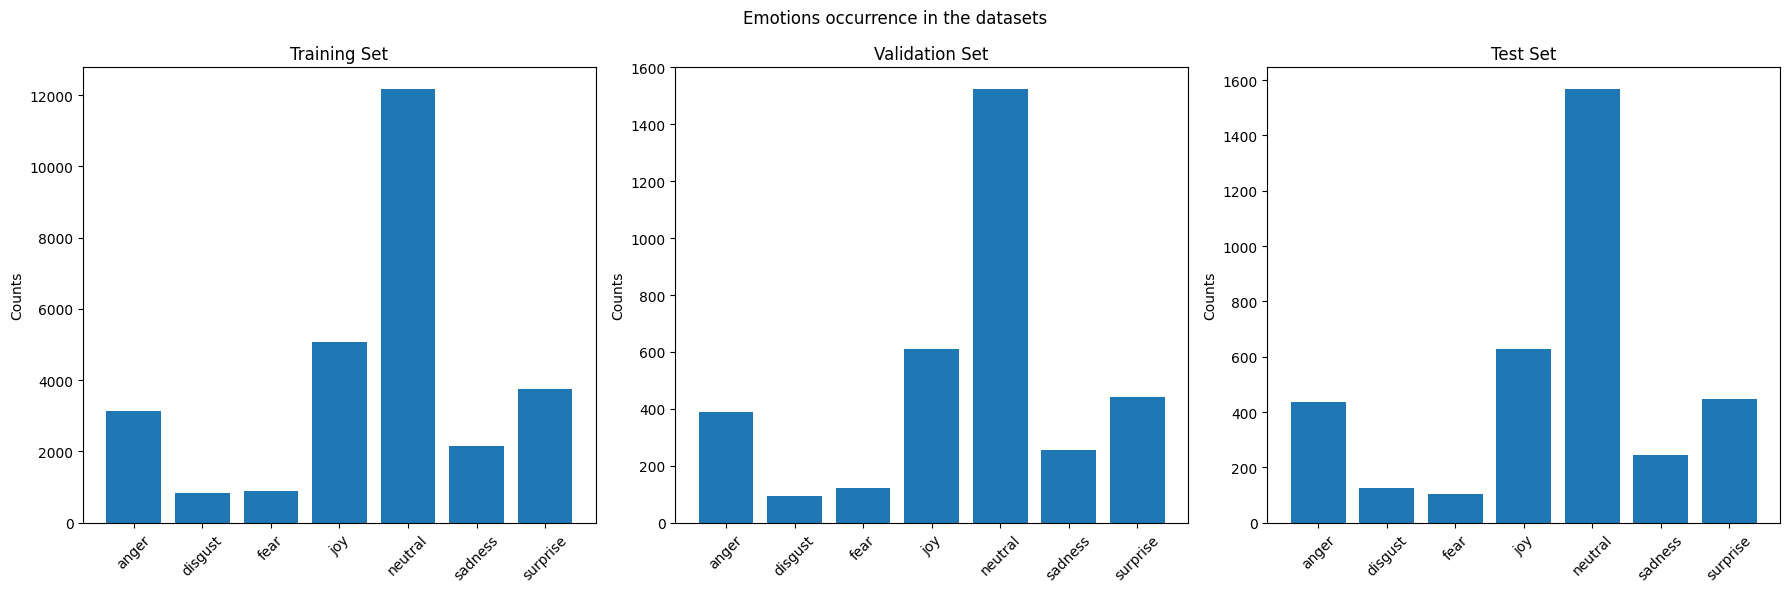

In [8]:
plot_emotion_distribution(train_df, val_df, test_df)

In [ ]:
# todo heatmap che associa a ogni personaggio il conto di emozioni che lo riguardano. Ogni riga contiene un'emozione, ogni colonna un personaggio. Esempio:
# Kristen -> (angry-40 volte), (joy, 20 volte), (disgust, 70 volte)...
# Joey -> (angry-23 volte), (joy, 50 volte) ...

# può essere interessante da fare per far vedere che facendo l'embedding dei singoli nomi distintamente il modello avrebbe il bias del nome (magari kristen porta molto disgusto, quindi tende ad assegnarglielo più facilmente)

## Random Classifier

In [9]:
# todo metric computation

emotions = np.unique([item for sublist in df["emotions"] for item in sublist]) # flattening and taking unique emotions
random_classifier = RandomClassifier(emotions)

pred_emotions, pred_triggers = random_classifier.predict(test_df)

# esempio di print per gli scettici che non crederanno che il classifier funziona
print(pred_emotions[0], pred_triggers[0])


['disgust', 'disgust', 'neutral', 'disgust', 'neutral', 'sadness', 'neutral', 'sadness', 'anger', 'surprise', 'anger'] [1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]


## Majority Classifier

In [10]:
# todo metrics computation

majority_classifier = MajorityClassifier()

majority_classifier.fit(train_df)
pred_emotions, pred_triggers = majority_classifier.predict(test_df)

# esempio di print per gli scettici che non crederanno che il classifier funziona
print(pred_emotions[0], pred_triggers[0])


['neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral'] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Bert Models

In [13]:
# first execution it downloads bert model and tokenizer, from second execution it retrieves them from local folder
if os.path.exists(BERT_DIRECTORY):
    bert_model, bert_tokenizer = retrieve_bert_initializers(BERT_DIRECTORY) 
else:
    bert_model, bert_tokenizer = download_bert_initializers(BERT_DIRECTORY) 


In [12]:
# cose da fare in ordine di priorità
# todo capire dove fare tokenization ed encoding (dentro il dataloader o fuori)? Poi farlo
# todo fare i dataloader

# todo Bert Models